In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.36'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [4]:
from utils import read_file

In [5]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_16KHz'
# CSV = DATA/'freesound/audio_44KHz/train.csv'
CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [6]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

print(df.shape)
df.head(3)

(9473, 3)


,fname,label,n_samples
0,00044347,Hi-hat,617400
1,001ca53d,Saxophone,455112
2,002d256b,Trumpet,19404


In [7]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,fname,label,n_samples
0,00063640,Laughter Hi-Hat Flute,69678
1,0013a1db,Laughter Hi-Hat Flute,36162
2,002bb878,Laughter Hi-Hat Flute,59094
3,002d392d,Laughter Hi-Hat Flute,22050
4,00326aa9,Laughter Hi-Hat Flute,91728


In [8]:
n_fft = 1024
n_hop = 256
n_mels = 96
sample_rate = 16000
top_db = 60.0
ref = 1.0

bs = 8

In [9]:
def rand_crop(signal):
    start_pct = 0.1
    end_pct = 0.4
    max_start = signal.shape[0] * start_pct
    max_end = signal.shape[0] * end_pct
    crop_start = int(np.random.rand() * max_start)
    crop_end = int(np.random.rand() * max_end) + 1
    
    s = signal[crop_start:-crop_end]
    if s.shape[0] == 0:
        import pdb; pdb.set_trace()
    return s

In [10]:
def random_stretch(mags, phases):
    pct = 0.2
    a,b = 1.0-pct, 1.0+pct
    r = np.random.rand() * (a - b) + b
    return phase_vocoder(mags, phases, rate=r)

def random_stretch_mags(mags):
    pct = 0.2
    a,b = 1.0-pct, 1.0+pct
    r = np.random.rand() * (a - b) + b
    return phase_vocoder_magnitude(mags, rate=r)

In [11]:
def get_transforms(n_fft=1024, n_hop=256, n_mels=96, sample_rate=16000):
    window = torch.hann_window(n_fft)
    to_db = ToDecibels(power=2, ref=ref, top_db=50.0, normalized=True)
    to_mel = FrequencyToMel(n_mels=n_mels, n_fft=n_fft, sr=sample_rate)
    to_mel.mel_filterbank = to_cpu(to_mel.mel_filterbank)

    def _train_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        x = rand_crop(x)
        X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
        power = power_spectrum(X)
        power = random_stretch_mags(power)
        power.unsqueeze_(0)
        mel_power = to_mel(power.transpose(1,2))
        mel_power_db = to_db(mel_power).squeeze_(0)
        return mel_power_db
    
    def _valid_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
        power = power_spectrum(X).unsqueeze_(0)
        mel_power = to_mel(power.transpose(1,2))
        mel_power_db = to_db(mel_power).squeeze_(0)
        return mel_power_db
    
    return [_train_tfm],[_valid_tfm]

In [20]:
tfm = get_transforms()[0][0]
tfm

<function __main__.get_transforms.<locals>._train_tfm(x)>

In [21]:
x = torch.zeros(0)
tfm(x).shape

torch.Size([96, 2])

In [12]:
def add_channel_dim(inputs):
    xs, ys = inputs
    xs.unsqueeze_(1)
    return xs, ys

In [13]:
test_data = AudioItemList.from_df(test_df, path=AUDIO, folder='test', suffix='.wav')
test_data

AudioItemList (9400 items)
[AudioClip (duration=1.58s, sample_rate=16.0KHz), AudioClip (duration=0.82s, sample_rate=16.0KHz), AudioClip (duration=1.34s, sample_rate=16.0KHz), AudioClip (duration=0.5s, sample_rate=16.0KHz), AudioClip (duration=2.08s, sample_rate=16.0KHz)]...
Path: data/freesound/audio_16KHz

In [14]:
data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
#             .add_test_folder('test')
            .transform(get_transforms())
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

In [15]:
# %%time
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([8, 1, 96, 1813]), torch.Size([8]), tensor(0.), tensor(1.5947))

In [16]:
model_name = 'freesound_16khz_1024_256_96_50db_v5'

learn = create_cnn(data, models.resnet18, metrics=[error_rate, mapk])

In [28]:
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')
# learn.load(model_name + '-stage-1');

epoch,train_loss,valid_loss,error_rate,mapk
1,2.999591,2.485124,0.673178,0.433474
2,2.567328,2.482941,0.691130,0.407867
3,2.452574,2.129538,0.557550,0.548398
4,2.150012,1.779602,0.499472,0.605509
5,2.049077,1.864100,0.504752,0.601989
6,1.887460,1.596175,0.421331,0.671242
7,1.729594,1.532519,0.406019,0.682682
8,1.831616,1.644038,0.436642,0.657955


In [29]:
# learn = create_cnn(data, models.resnet18, metrics=[error_rate, mapk])
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-2);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


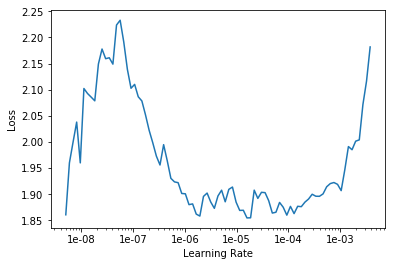

In [30]:
learn.recorder.plot()

In [31]:
# learn = create_cnn(data, models.resnet18, metrics=[error_rate, mapk])
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=slice(1e-7,1e-6))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.646701,1.697791,0.439282,0.654963
2,1.751569,1.621840,0.426610,0.665171
3,1.685170,1.683598,0.426082,0.663499
4,1.775013,1.549822,0.397571,0.684882
5,1.804803,1.917088,0.500000,0.603749
6,1.696957,1.612871,0.410243,0.676346
7,1.715457,1.561242,0.410771,0.678370
8,1.705778,1.518851,0.391235,0.694826


In [18]:
learn.load(model_name + '-stage-2');

In [24]:
def save_submission(learner, filename, tta=False):
    fnames = [Path(f).name for f in learn.data.test_ds.x.items]
    get_predsfn = learn.TTA if tta else learn.get_preds
    preds = get_predsfn(ds_type=DatasetType.Test)[0]
    top_3 = np.array(learn.data.classes)[np.argsort(-preds, axis=1)[:, :3]]
    labels = [' '.join(list(x)) for x in top_3]
    df = pd.DataFrame({'fname': fnames, 'label': labels})
    df.to_csv(filename, index=False)
    return df

In [25]:
df1 = save_submission(learn, 'test_16khz_2.csv', tta=False)

In [ ]:
df2 = save_submission(learn, 'test_16khz_tta_2.csv', tta=True)

In [29]:
df1.to_csv('test_16khz_2.csv', index=False)


In [32]:
learn.get_preds?

Signature:
learn.get_preds(
    ['ds_type:fastai.basic_data.DatasetType=<DatasetType.Valid: 2>', 'with_loss:bool=False', 'n_batch:Union[int, NoneType]=None', 'pbar:Union[fastprogress.fastprogress.MasterBar, fastprogress.fastprogress.ProgressBar, NoneType]=None'],
) -> List[torch.Tensor]
Docstring: Return predictions and targets on `ds_type` dataset.
File:      /opt/anaconda3/lib/python3.6/site-packages/fastai/basic_train.py
Type:      method


In [35]:
learn.data.test_dl.items

array(['data/freesound/audio_16KHz/test/00063640.wav', 'data/freesound/audio_16KHz/test/0013a1db.wav',
       'data/freesound/audio_16KHz/test/002bb878.wav', 'data/freesound/audio_16KHz/test/002d392d.wav', ...,
       'data/freesound/audio_16KHz/test/ffe8d42d.wav', 'data/freesound/audio_16KHz/test/ffeba2cd.wav',
       'data/freesound/audio_16KHz/test/fff6d073.wav', 'data/freesound/audio_16KHz/test/fff8d22d.wav'], dtype=object)

In [39]:
learn.data.test_dl.dl.sampler

In [41]:
next(iter(learn.data.test_dl))

(tensor([[[[ 0.4245,  0.4245,  0.4245,  ...,  0.4245,  0.4245,  0.4245],
           [ 0.4245,  0.4245,  0.4245,  ...,  0.4245,  0.4245,  0.4245],
           [ 0.4245,  0.4245,  0.4245,  ...,  0.4245,  0.4245,  0.4245],
           ...,
           [ 0.4245,  0.4245,  0.4245,  ...,  0.4245,  0.4245,  0.4245],
           [ 0.4245,  0.4245,  0.4245,  ...,  0.4245,  0.4245,  0.4245],
           [ 0.4245,  0.4245,  0.4245,  ...,  0.4245,  0.4245,  0.4245]]],
 
 
         [[[ 0.3926,  0.3926,  0.5728,  ...,  0.5513,  0.0000,  0.0000],
           [ 0.3926,  0.3926,  0.3926,  ...,  0.3926,  0.0000,  0.0000],
           [ 0.3926,  0.3926,  0.3926,  ...,  0.4611,  0.0000,  0.0000],
           ...,
           [ 0.3926,  0.3926,  0.3926,  ...,  0.3926,  0.0000,  0.0000],
           [ 0.3926,  0.3926,  0.3926,  ...,  0.3926,  0.0000,  0.0000],
           [ 0.3926,  0.3926,  0.3926,  ...,  0.3926,  0.0000,  0.0000]]],
 
 
         [[[ 0.3853,  0.4165,  0.4152,  ...,  0.0000,  0.0000,  0.0000],
       